## Mod 3 Project
## Ben Inoyatov
# Looking at Diabetes in Pima Native American Women

In [346]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import scipy.stats as stats
plt.style.use('ggplot')


from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import VotingClassifier, RandomForestClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV, LinearRegression
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import precision_score, accuracy_score, f1_score, recall_score, plot_roc_curve, plot_confusion_matrix
from sklearn.feature_selection import RFECV, SelectKBest, f_regression
from sklearn.utils import resample
from sklearn import metrics

pd.set_option('display.max_columns', 100)

In [347]:
d = pd.read_csv('diabetes.csv')
d.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


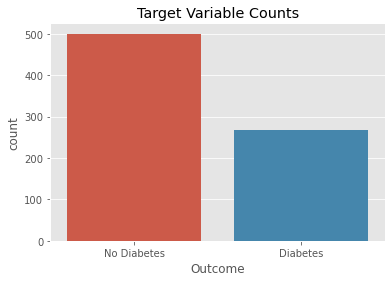

In [348]:
sns.countplot(x=d.Outcome)
plt.title('Target Variable Counts')
plt.xticks(ticks=[0,1],labels=['No Diabetes', 'Diabetes'])
plt.savefig('target_count.png')

## EDA

In [349]:
d.shape

(768, 9)

In [350]:
d.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [351]:
print('count of 0\'s in columns:')
d[d[['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome']] == 0].count()

count of 0's in columns:


Pregnancies                 111
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                     500
dtype: int64

### Zero values for glucose, bp, skin thickness, insulin and bmi
  - Pregnancies, pedigree function, age and outcome: zero values makes sense here so we leave them
  - For glucose, bp, skin thickness, insulin and bmi, we will investigate how to impute. There should be a value for those rows since they are measurable vital signs
  - For now however, we'll impute nans so we can better visualize our data before impution 

In [352]:
# replacing zeros to nans for each column mentioned above

d_nan = d[['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI']].replace(0,np.nan)


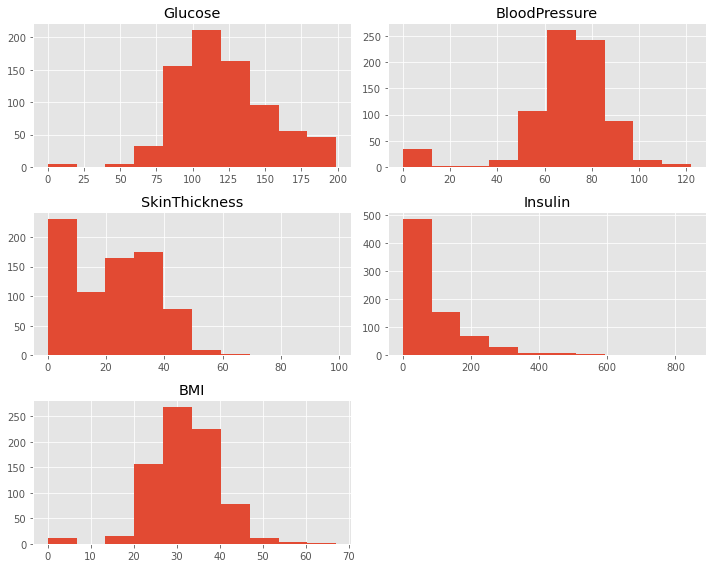

In [353]:
# original hist

d[['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI']].hist(figsize=(10,8));
plt.tight_layout()

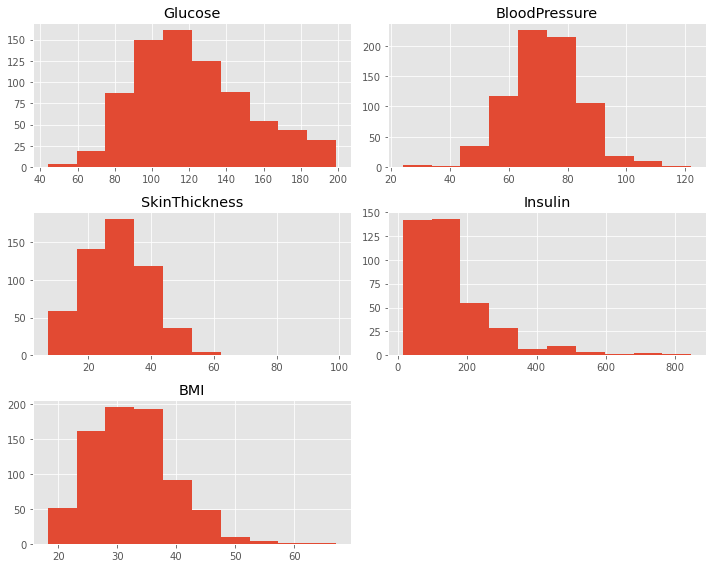

In [354]:
# hist with nans
d_nan.hist(figsize=(10,8));
plt.tight_layout()

### Except for insulin, the data is fairly normal 
  - Lets look at averages for those who have diabetes and those who do not
 

In [355]:
# first merge tables to make third working df, d_new

d_new = d_nan.copy()
d_new['Pregnancies'] = d.Pregnancies
d_new['DiabetesPedigreeFunction'] = d.DiabetesPedigreeFunction
d_new['Age'] = d.Age
d_new['Outcome'] = d.Outcome
d_new.head()

,Glucose,BloodPressure,SkinThickness,Insulin,BMI,Pregnancies,DiabetesPedigreeFunction,Age,Outcome
0,148.0,72.0,35.0,NaN,33.6,6,0.627,50,1
1,85.0,66.0,29.0,NaN,26.6,1,0.351,31,0
2,183.0,64.0,NaN,NaN,23.3,8,0.672,32,1
3,89.0,66.0,23.0,94.0,28.1,1,0.167,21,0
4,137.0,40.0,35.0,168.0,43.1,0,2.288,33,1


### Grouping features by outcome, getting their mean and medians for statistical tests

In [356]:
d_new.groupby(['Outcome'])[['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Pregnancies', 'Age']].agg(['mean', 'count', 'std'])

Glucose                  BloodPressure                   \
               mean count        std          mean count        std   
Outcome                                                               
0        110.643863   497  24.776906     70.877339   481  12.161223   
1        142.319549   266  29.599199     75.321429   252  12.299866   

        SkinThickness                      Insulin                    \
                 mean count        std        mean count         std   
Outcome                                                                
0           27.235457   361  10.026491  130.287879   264  102.482237   
1           33.000000   180  10.327595  206.846154   130  132.699898   

               BMI                 DiabetesPedigreeFunction                  \
              mean count       std                     mean count       std   
Outcome                                                                       
0        30.859674   491  6.560737                 0.429734   500  0.299085   
1        35.406767   266  6.614982                 0.550500   268  0.372354   

        Pregnancies                        Age                   
               mean count       std       mean count        std  
Outcome                                                          
0          3.298000   500  3.017185  31.190000   500  11.667655  
1          4.865672   268  3.741239  37.067164   268  10.968254

In [357]:
d_new.head()

,Glucose,BloodPressure,SkinThickness,Insulin,BMI,Pregnancies,DiabetesPedigreeFunction,Age,Outcome
0,148.0,72.0,35.0,NaN,33.6,6,0.627,50,1
1,85.0,66.0,29.0,NaN,26.6,1,0.351,31,0
2,183.0,64.0,NaN,NaN,23.3,8,0.672,32,1
3,89.0,66.0,23.0,94.0,28.1,1,0.167,21,0
4,137.0,40.0,35.0,168.0,43.1,0,2.288,33,1


In [358]:
# statistical tests on averages 
gl0 = d.query('Outcome == 0')["Glucose"]
gl1 = d.query('Outcome == 1')["Glucose"]
t_stat, pval = stats.f_oneway(gl0,gl1)
t_stat, pval

(213.1617521780386, 8.935431645287658e-43)

In [359]:
gavg = d_new.groupby(['Outcome'])['Glucose'].mean()
bpmed = d_new.groupby(['Outcome'])['BloodPressure'].median()
stmed = d_new.groupby(['Outcome'])['SkinThickness'].median()
inmed = d_new.groupby(['Outcome'])['Insulin'].median()
bmimed = d_new.groupby(['Outcome'])['BMI'].median()

### Median is better to use if the data has outliers, lets take a look

<AxesSubplot:>

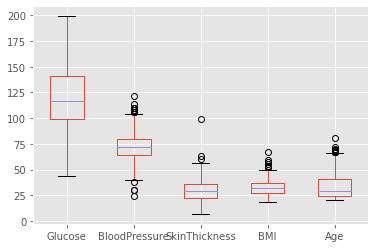

In [360]:
d_new.boxplot(column=['Glucose', 'BloodPressure', 'SkinThickness', 'BMI', 'Age'])

<AxesSubplot:>

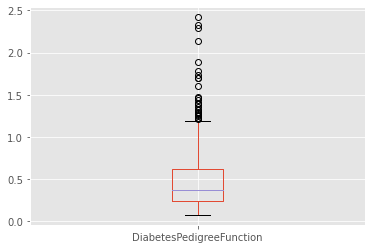

In [361]:
d_new.boxplot(column=['DiabetesPedigreeFunction'])

### Use mean for glucose and median for the rest 

In [362]:
d_new.loc[(d_new['Outcome'] == 0 ) & (d_new['Glucose'].isnull()), 'Glucose'] = gavg[0]
d_new.loc[(d_new['Outcome'] == 1 ) & (d_new['Glucose'].isnull()), 'Glucose'] = gavg[1]

d_new.loc[(d_new['Outcome'] == 0 ) & (d_new['BloodPressure'].isnull()), 'BloodPressure'] = bpmed[0]
d_new.loc[(d_new['Outcome'] == 1 ) & (d_new['BloodPressure'].isnull()), 'BloodPressure'] = bpmed[1]

d_new.loc[(d_new['Outcome'] == 0 ) & (d_new['SkinThickness'].isnull()), 'SkinThickness'] = stmed[0]
d_new.loc[(d_new['Outcome'] == 1 ) & (d_new['SkinThickness'].isnull()), 'SkinThickness'] = stmed[1]

d_new.loc[(d_new['Outcome'] == 0 ) & (d_new['Insulin'].isnull()), 'Insulin'] = inmed[0]
d_new.loc[(d_new['Outcome'] == 1 ) & (d_new['Insulin'].isnull()), 'Insulin'] = inmed[1]

d_new.loc[(d_new['Outcome'] == 0 ) & (d_new['BMI'].isnull()), 'BMI'] = bmimed[0]
d_new.loc[(d_new['Outcome'] == 1 ) & (d_new['BMI'].isnull()), 'BMI'] = bmimed[1]

In [363]:
d_new.isna().any()

Glucose                     False
BloodPressure               False
SkinThickness               False
Insulin                     False
BMI                         False
Pregnancies                 False
DiabetesPedigreeFunction    False
Age                         False
Outcome                     False
dtype: bool

Before imputing:  [<AxesSubplot:title={'center':'0'}> <AxesSubplot:title={'center':'1'}>]


After imputing:  [<AxesSubplot:title={'center':'0'}> <AxesSubplot:title={'center':'1'}>]


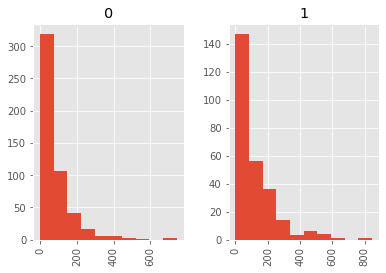

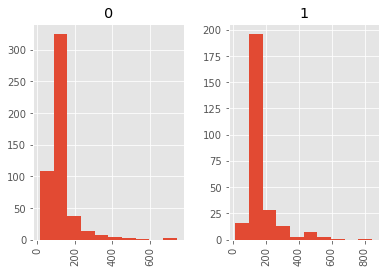

In [364]:
# 
print('Before imputing: ', d.Insulin.hist(by=d.Outcome))

print('\n')
print('After imputing: ', d_new.Insulin.hist(by=d.Outcome))

<Figure size 432x288 with 0 Axes>

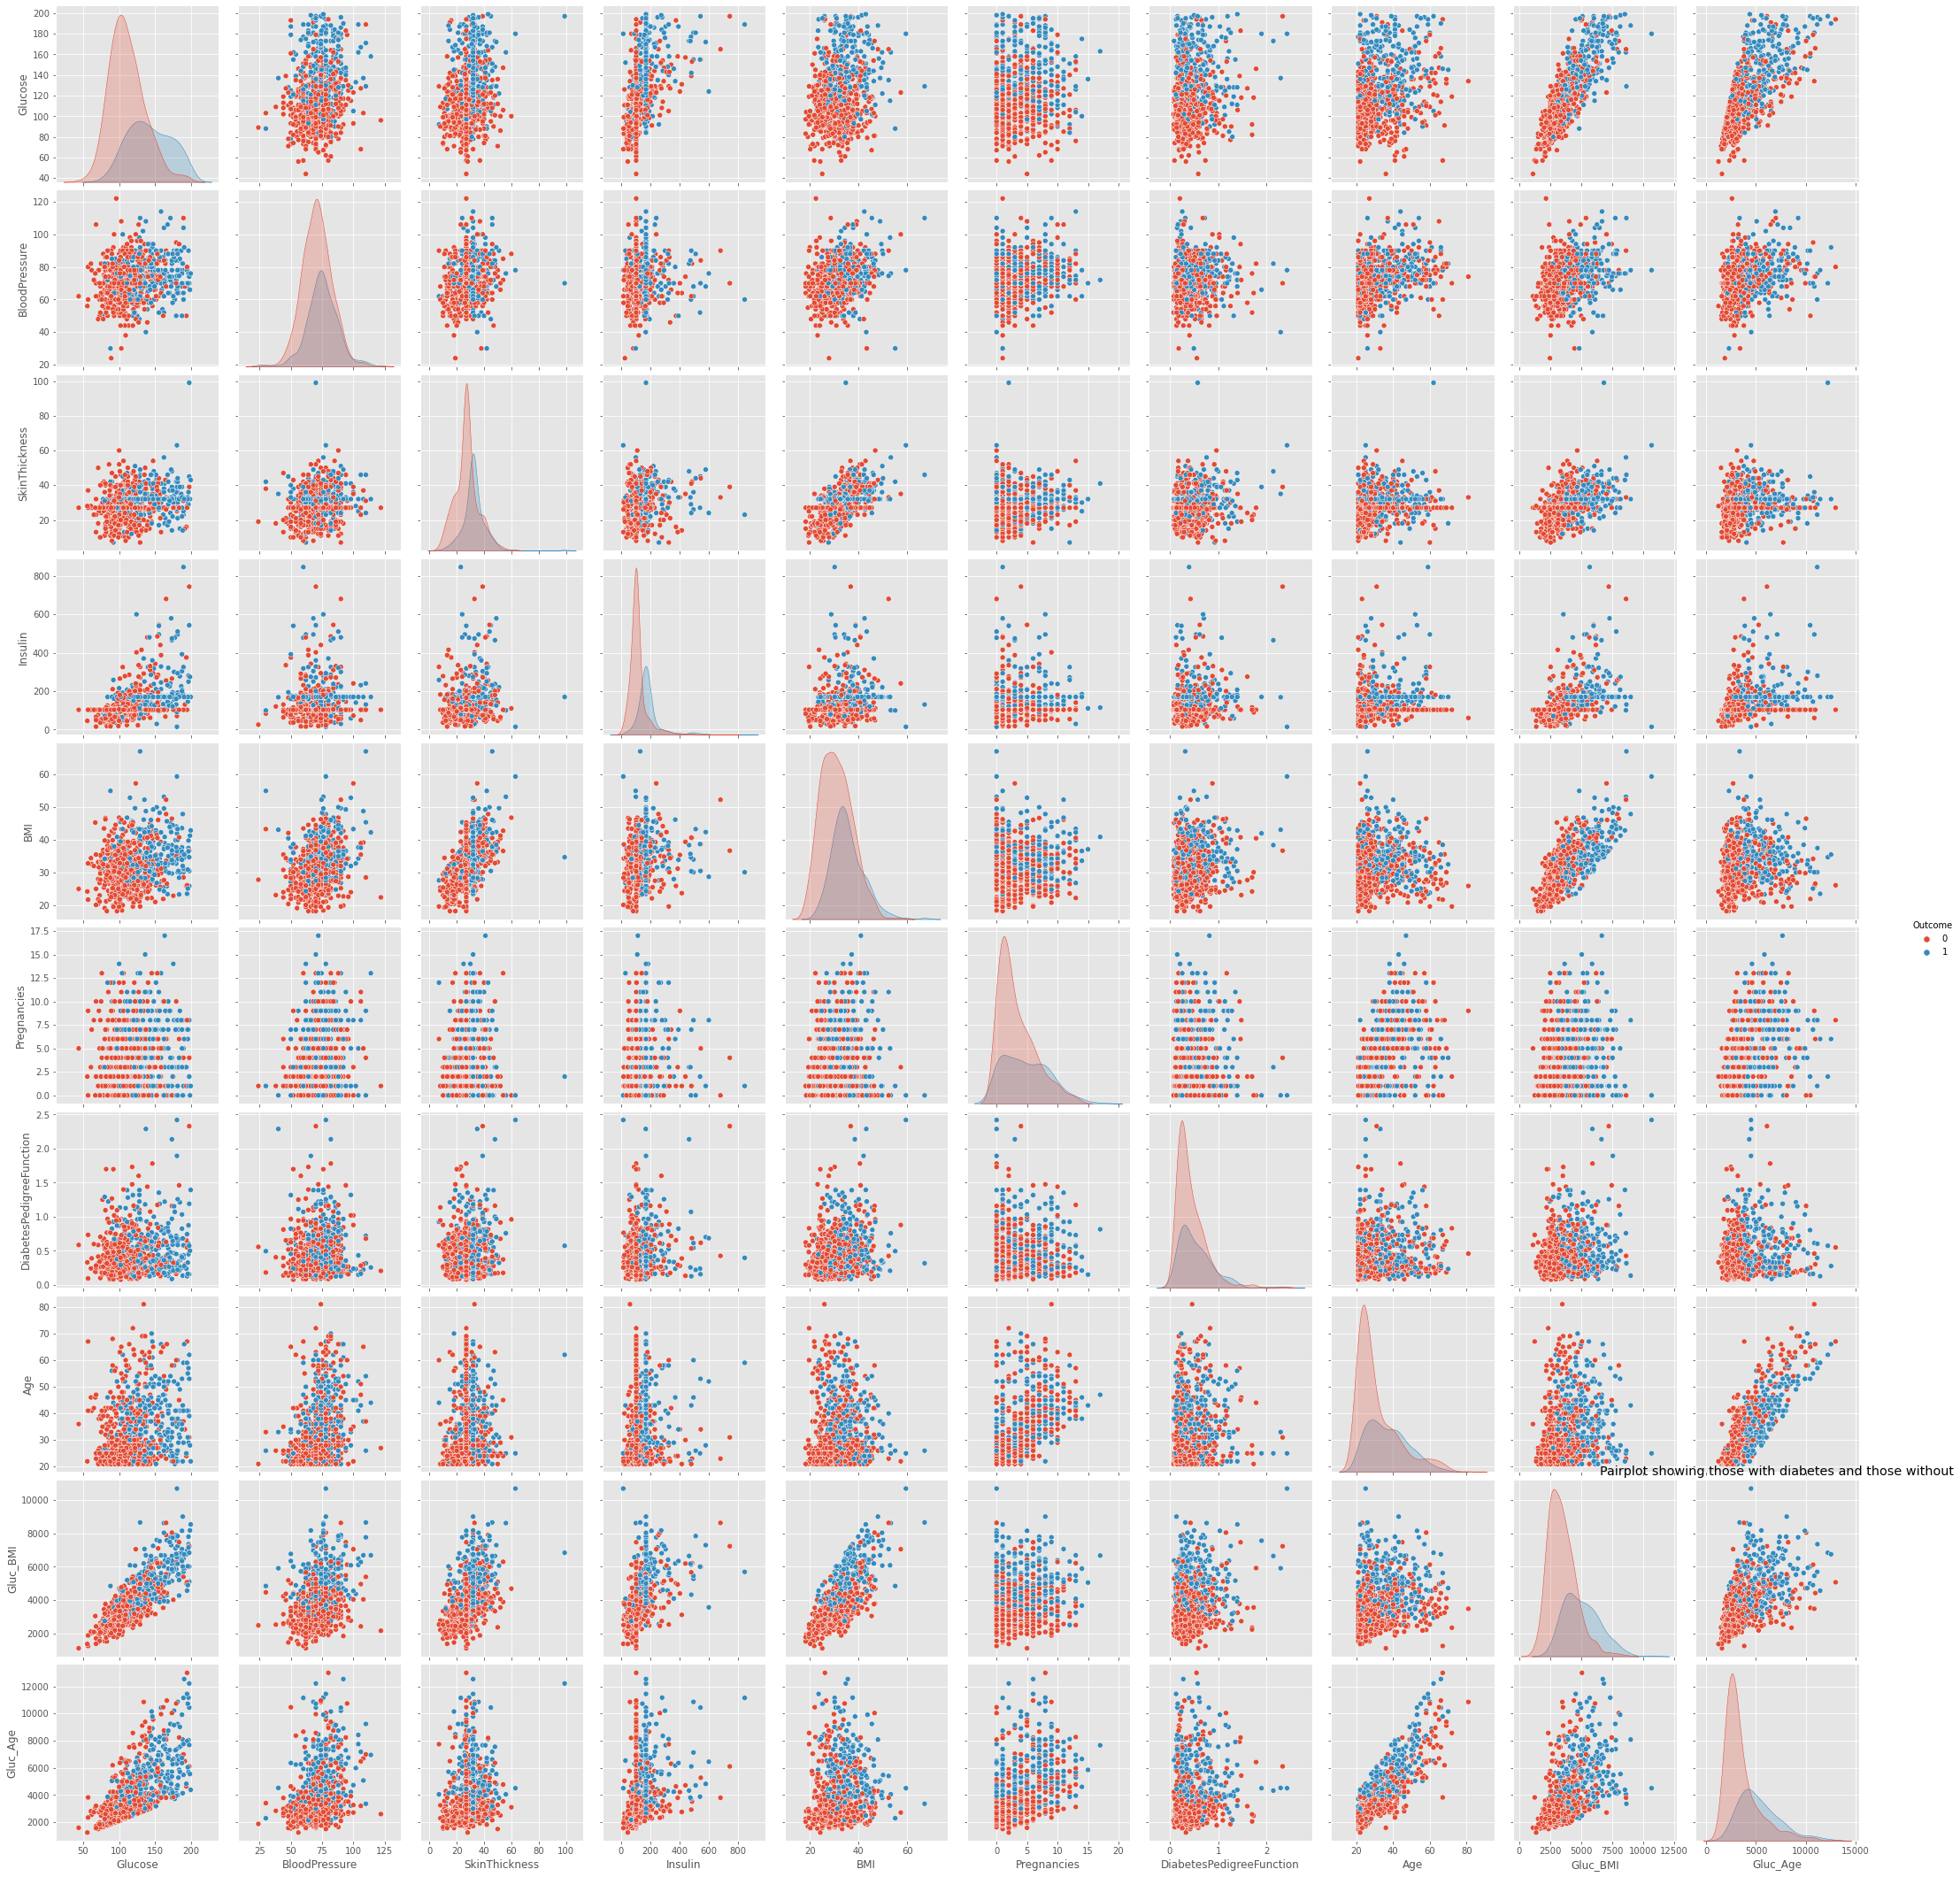

In [394]:
plt.figure()
sns.pairplot(d_new, hue = "Outcome", height=3)
plt.title('Pairplot showing those with diabetes and those without')
plt.savefig('pairplot.png')
plt.show()

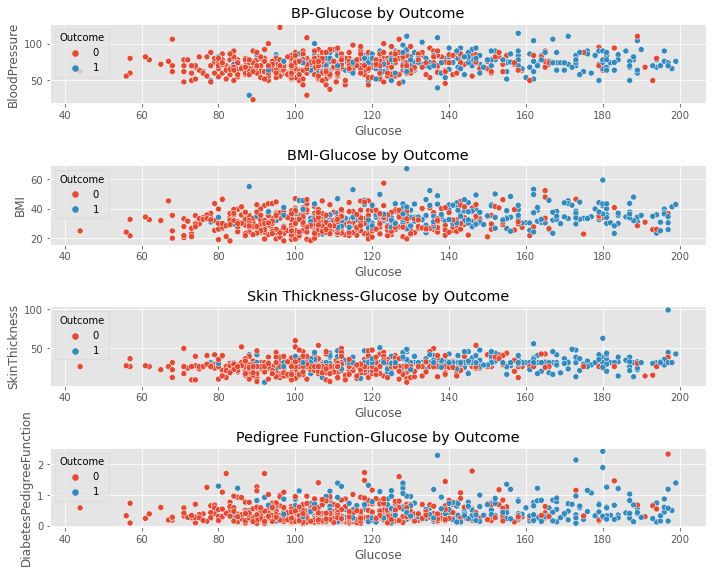

In [365]:
fig, (ax1,ax2,ax3,ax4) = plt.subplots(4, figsize=(10,8))
sns.scatterplot(x=d_new.Glucose, y=d_new.BloodPressure,hue=d_new.Outcome, ax=ax1)
sns.scatterplot(x=d_new.Glucose, y=d_new.BMI,hue=d_new.Outcome,ax=ax2)
sns.scatterplot(x=d_new.Glucose, y=d_new.SkinThickness,hue=d_new.Outcome,ax=ax3)
sns.scatterplot(x=d_new.Glucose, y=d_new.DiabetesPedigreeFunction,hue=d_new.Outcome,ax=ax4)

ax1.set_title('BP-Glucose by Outcome')
ax2.set_title('BMI-Glucose by Outcome')
ax3.set_title('Skin Thickness-Glucose by Outcome')
ax4.set_title('Pedigree Function-Glucose by Outcome')

plt.tight_layout();
plt.savefig('gluce.png')
plt.show();

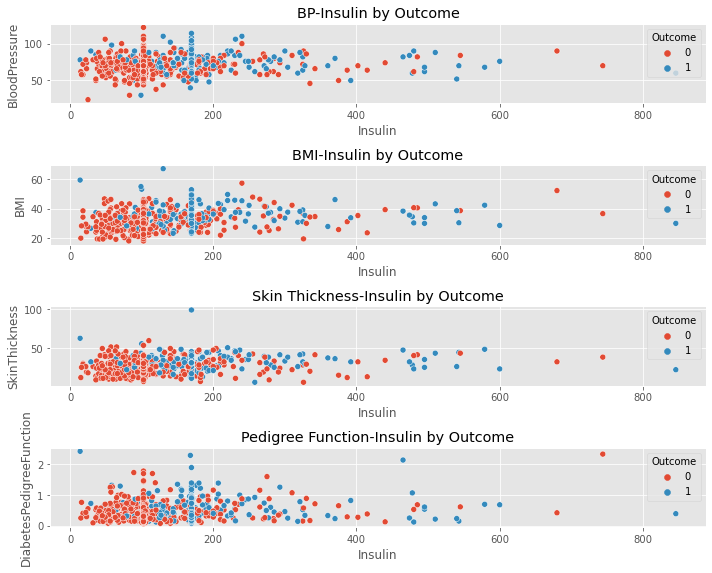

In [397]:
fig, (ax1,ax2,ax3,ax4) = plt.subplots(4, figsize=(10,8))
sns.scatterplot(x=d_new.Insulin, y=d_new.BloodPressure,hue=d_new.Outcome, ax=ax1)
sns.scatterplot(x=d_new.Insulin, y=d_new.BMI,hue=d_new.Outcome,ax=ax2)
sns.scatterplot(x=d_new.Insulin, y=d_new.SkinThickness,hue=d_new.Outcome,ax=ax3)
sns.scatterplot(x=d_new.Insulin, y=d_new.DiabetesPedigreeFunction,hue=d_new.Outcome,ax=ax4)

ax1.set_title('BP-Insulin by Outcome')
ax2.set_title('BMI-Insulin by Outcome')
ax3.set_title('Skin Thickness-Insulin by Outcome')
ax4.set_title('Pedigree Function-Insulin by Outcome')

plt.tight_layout();
plt.savefig('insulin.png')
plt.show();

<AxesSubplot:>

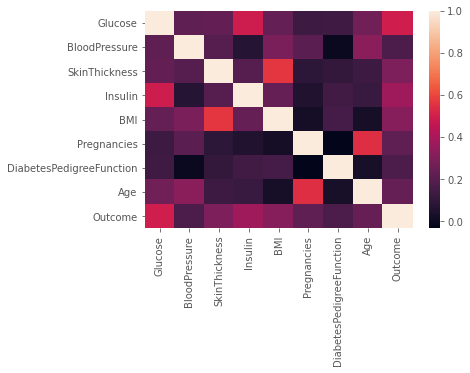

In [366]:
corr=d_new.corr()
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns)

In [367]:
d_new.corr() >.28

,Glucose,BloodPressure,SkinThickness,Insulin,BMI,Pregnancies,DiabetesPedigreeFunction,Age,Outcome
Glucose,True,False,False,True,False,False,False,False,True
BloodPressure,False,True,False,False,True,False,False,True,False
SkinThickness,False,False,True,False,True,False,False,False,True
Insulin,True,False,False,True,False,False,False,False,True
BMI,False,True,True,False,True,False,False,False,True
Pregnancies,False,False,False,False,False,True,False,True,False
DiabetesPedigreeFunction,False,False,False,False,False,False,True,False,False
Age,False,True,False,False,False,True,False,True,False
Outcome,True,False,True,True,True,False,False,False,True


In [368]:
# Feature Enginner: interaction between glucose and bmi/age 

In [369]:
d_new['Gluc_BMI'] = d_new.Glucose * d_new.BMI
d_new['Gluc_Age'] = d_new.Glucose * d_new.Age
d_new.head()

,Glucose,BloodPressure,SkinThickness,Insulin,BMI,Pregnancies,DiabetesPedigreeFunction,Age,Outcome,Gluc_BMI,Gluc_Age
0,148.0,72.0,35.0,169.5,33.6,6,0.627,50,1,4972.8,7400.0
1,85.0,66.0,29.0,102.5,26.6,1,0.351,31,0,2261.0,2635.0
2,183.0,64.0,32.0,169.5,23.3,8,0.672,32,1,4263.9,5856.0
3,89.0,66.0,23.0,94.0,28.1,1,0.167,21,0,2500.9,1869.0
4,137.0,40.0,35.0,168.0,43.1,0,2.288,33,1,5904.7,4521.0


In [370]:
d_new.to_csv('cleaned.csv')

# END OF EDA # 
---
## Modeling

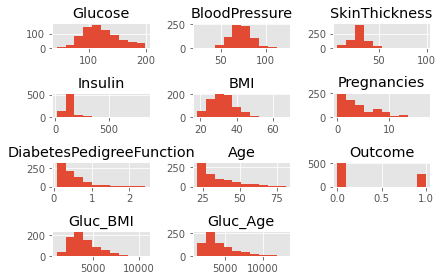

In [371]:
d_new.hist();
plt.tight_layout()
plt.savefig('d_new_hist.png')

In [372]:
def print_metrics(labels, preds):
    print("Precision Score: {}".format(precision_score(labels, preds)))
    print("Recall Score: {}".format(recall_score(labels, preds)))
    print("Accuracy Score: {}".format(accuracy_score(labels, preds)))
    print("F1 Score: {}".format(f1_score(labels, preds)))

## First some basic linear/logistic regressions

In [373]:
X = d_new.drop(columns='Outcome', axis=1)
y = d_new.Outcome

# splitting into testing and training data 
X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=7,test_size=0.33)

# instantiating the normal scaler class
scaler = StandardScaler()

# fit the scaler to the training data
scaler.fit(X_train)

#transform the training data and re-assign X_train 
X_train = pd.DataFrame(data=scaler.transform(X_train), columns=X.columns)

#transform the testing data and re-assign X_test
X_test = pd.DataFrame(data=scaler.transform(X_test), columns=X.columns)

In [374]:
linreg=LinearRegression()
linreg.fit(X_train, y_train)
testpred = linreg.predict(X_test)
trainpred=linreg.predict(X_train)
linreg.coef_

trainK_rmse = np.sqrt(metrics.mean_squared_error(y_train, trainpred))

print('Training RMSE: ', trainK_rmse)

testK_rmse = np.sqrt(metrics.mean_squared_error(y_test, testpred))

print('Testing Root Mean Squared Error:' , testK_rmse)


Training RMSE:  0.37972528557324664
Testing Root Mean Squared Error: 0.4047160520528811


### Feature engineering: polynomial features, 2nd degree

In [241]:
poly = PolynomialFeatures(degree=2, include_bias=False)
polydata = poly.fit_transform(d_new)
polycols = poly.get_feature_names(d_new.columns)
polydf = pd.DataFrame(data=polydata, columns=polycols)

polyX = polydf.drop(columns='Outcome', axis=1)
polyy = polydf.Outcome

X_train, X_test, y_train, y_test = train_test_split(
    polyX, polyy, random_state=7,test_size=0.33)

lr = LinearRegression()
lr.fit(X_train,y_train)
testpred = lr.predict(X_test)
trainpred = lr.predict(X_train)

trainK_rmse = np.sqrt(metrics.mean_squared_error(y_train, trainpred))

print('Training RMSE: ', trainK_rmse)

testK_rmse = np.sqrt(metrics.mean_squared_error(y_test, testpred))

print('Testing Root Mean Squared Error:' , testK_rmse)

Training RMSE:  1.3577559603349116e-13
Testing Root Mean Squared Error: 1.8001980510666907e-13


#### Too many polynomials lead to overfitting, lets use KSelectBest to shorten it down 
---

In [242]:
selector = SelectKBest(f_regression, k=20)
selector.fit(X_train, y_train)
selected_columns = X_train.columns[selector.get_support()]
selected_columns

Index(['Glucose', 'Gluc_BMI', 'Glucose^2', 'Glucose SkinThickness',
       'Glucose BMI', 'Glucose Outcome', 'Glucose Gluc_BMI',
       'BloodPressure Outcome', 'SkinThickness Outcome', 'Insulin Outcome',
       'BMI Outcome', 'BMI Gluc_Age', 'Pregnancies Outcome',
       'DiabetesPedigreeFunction Outcome', 'Age Outcome', 'Age Gluc_BMI',
       'Outcome Gluc_BMI', 'Outcome Gluc_Age', 'Gluc_BMI^2',
       'Gluc_BMI Gluc_Age'],
      dtype='object')

In [243]:
lrkbest = LinearRegression()
lrkbest.fit(X_train[selected_columns], y_train)
testpred = lrkbest.predict(X_test[selected_columns])
trainpred = lrkbest.predict(X_train[selected_columns])
testrmse = np.sqrt(metrics.mean_squared_error(y_test, testpred))
trainrmse = np.sqrt(metrics.mean_squared_error(y_train, trainpred))
print('Training Root Mean Squared Error:', trainrmse)
print('Testing Root Mean Squared Error:' , testrmse)

Training Root Mean Squared Error: 0.012062809012930817
Testing Root Mean Squared Error: 0.01518830835822053


---

###  logistic regression

In [375]:
X = d_new.drop(columns='Outcome', axis=1)
y = d_new.Outcome

# splitting into testing and training data 
X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=7,test_size=0.33)

# instantiating the normal scaler class
scaler = StandardScaler()

# fit the scaler to the training data
scaler.fit(X_train)

#transform the training data and re-assign X_train 
X_train = pd.DataFrame(data=scaler.transform(X_train), columns=X.columns)

#transform the testing data and re-assign X_test
X_test = pd.DataFrame(data=scaler.transform(X_test), columns=X.columns)

In [376]:
log_reg = LogisticRegression(solver='liblinear', random_state=7)
log_reg.fit(X_train, y_train)
testpreds=log_reg.predict(X_test)
trainpreds=log_reg.predict(X_train)
print('Logistic Regression')
print('------------------')

print('\r')

print('Training Metrics:')
print('------------------')
print_metrics(y_train, trainpreds)
trainK_rmse = np.sqrt(metrics.mean_squared_error(y_train, trainpreds))

print('Training RMSE: ', trainK_rmse)
print('\r')
print('Test Metrics:')
print('------------------')
print_metrics(y_test, testpreds)



testK_rmse = np.sqrt(metrics.mean_squared_error(y_test, testpreds))

print('Testing Root Mean Squared Error:' , testK_rmse)

Logistic Regression
------------------

Training Metrics:
------------------
Precision Score: 0.7394366197183099
Recall Score: 0.5965909090909091
Accuracy Score: 0.7898832684824902
F1 Score: 0.660377358490566
Training RMSE:  0.45838491632852596

Test Metrics:
------------------
Precision Score: 0.7209302325581395
Recall Score: 0.6739130434782609
Accuracy Score: 0.7874015748031497
F1 Score: 0.6966292134831461
Testing Root Mean Squared Error: 0.46108396762070397


In [246]:
# this model has been tuned many times using the gridserach below 
lr_ridge = LogisticRegressionCV(solver='liblinear',cv=15,penalty='l2',scoring='f1',class_weight='balanced',n_jobs=-1, random_state=7)

lr_ridge.fit(X_train, y_train)
testpred=lr_ridge.predict(X_test)
trainpred=lr_ridge.predict(X_train)

print('Training Metrics:')
print('------------------')
print_metrics(y_train, trainpred)
trainK_rmse = np.sqrt(metrics.mean_squared_error(y_train, trainpred))

print('Training RMSE: ', trainK_rmse)

print('\r')
print('Test Metrics:')
print('------------------')
print_metrics(y_test, testpred)


testK_rmse = np.sqrt(metrics.mean_squared_error(y_test, testpred))

print('Testing Root Mean Squared Error:' , testK_rmse)

Training Metrics:
------------------
Precision Score: 0.6697674418604651
Recall Score: 0.8181818181818182
Accuracy Score: 0.7996108949416343
F1 Score: 0.7365728900255756
Training RMSE:  0.44764841679421336

Test Metrics:
------------------
Precision Score: 0.6724137931034483
Recall Score: 0.8478260869565217
Accuracy Score: 0.7952755905511811
F1 Score: 0.75
Testing Root Mean Squared Error: 0.45246481570263436


#### Gridsearch cv for logreg 

In [248]:
gslogreg = LogisticRegression(solver='liblinear',random_state=7)

param = {'penalty': ['l1', 'l2'],
        'class_weight': [None, 'balanced'],
        'C': [0.01,0.1,0.25,0.35,0.5,0.75,1.0],
        'max_iter': [30,40,50,100,200]}
gs = GridSearchCV(gslogreg, param, cv=15, scoring='f1')
gs.fit(X_train,y_train)

GridSearchCV(cv=15,
             estimator=LogisticRegression(random_state=7, solver='liblinear'),
             param_grid={'C': [0.01, 0.1, 0.25, 0.35, 0.5, 0.75, 1.0],
                         'class_weight': [None, 'balanced'],
                         'max_iter': [30, 40, 50, 100, 200],
                         'penalty': ['l1', 'l2']},
             scoring='f1')

In [249]:
testpred = gs.predict(X_test)
trainpred = gs.predict(X_train)

print('Grid Search for Logistic Regression')
print('------------------')
print('\r')
print('Training Metrics:')
print('------------------')
print_metrics(y_train, trainpred)
trainK_rmse = np.sqrt(metrics.mean_squared_error(y_train, trainpred))

print('Training RMSE: ', trainK_rmse)
print('\r')
print('Test Metrics:')
print('------------------')
print_metrics(y_test, testpred)



testK_rmse = np.sqrt(metrics.mean_squared_error(y_test, testpred))

print('Testing Root Mean Squared Error:' , testK_rmse)

Grid Search for Logistic Regression
------------------

Training Metrics:
------------------
Precision Score: 0.6712962962962963
Recall Score: 0.8238636363636364
Accuracy Score: 0.8015564202334631
F1 Score: 0.7397959183673469
Training RMSE:  0.44547006607238715

Test Metrics:
------------------
Precision Score: 0.6610169491525424
Recall Score: 0.8478260869565217
Accuracy Score: 0.7874015748031497
F1 Score: 0.7428571428571429
Testing Root Mean Squared Error: 0.46108396762070397


In [250]:
print(gs.best_estimator_)
print(gs.best_params_)

LogisticRegression(C=0.1, class_weight='balanced', max_iter=30, penalty='l1',
                   random_state=7, solver='liblinear')
{'C': 0.1, 'class_weight': 'balanced', 'max_iter': 30, 'penalty': 'l1'}


#### Gridsearch final logistic regression model - will use for voting classifier later

In [251]:
final_logreg = LogisticRegression(C=0.1, class_weight='balanced', max_iter=30, random_state=7,
                   solver='liblinear', penalty='l1')
final_logreg.fit(X_train, y_train)
testpred=final_logreg.predict(X_test)
trainpred=final_logreg.predict(X_train)

print('Training Metrics:')
print('------------------')
print_metrics(y_train, trainpred)
trainK_rmse = np.sqrt(metrics.mean_squared_error(y_train, trainpred))

print('Training RMSE: ', trainK_rmse)
print('\r')
print('Test Metrics:')
print('------------------')
print_metrics(y_test, testpred)


testK_rmse = np.sqrt(metrics.mean_squared_error(y_test, testpred))

print('Testing Root Mean Squared Error:' , testK_rmse)
cross_val_score(final_logreg, X_train, y_train)

Training Metrics:
------------------
Precision Score: 0.6712962962962963
Recall Score: 0.8238636363636364
Accuracy Score: 0.8015564202334631
F1 Score: 0.7397959183673469
Training RMSE:  0.44547006607238715

Test Metrics:
------------------
Precision Score: 0.6610169491525424
Recall Score: 0.8478260869565217
Accuracy Score: 0.7874015748031497
F1 Score: 0.7428571428571429
Testing Root Mean Squared Error: 0.46108396762070397


array([0.81553398, 0.78640777, 0.73786408, 0.83495146, 0.75490196])


---

### log reg with sampling to deal with target class imbalance

### upsampling the minority class 

In [252]:
has_diabetes = d_new[d_new.Outcome==1]
no_diabetes = d_new[d_new.Outcome==0]

upsampled = resample(has_diabetes, replace=True, n_samples=len(no_diabetes), random_state=7)
upsampled = pd.concat([no_diabetes, upsampled])
upsampled.Outcome.value_counts()

1    500
0    500
Name: Outcome, dtype: int64

In [253]:
# new train sets 
upnew_X = upsampled.drop(columns='Outcome', axis=1)
upnew_y = upsampled.Outcome
upX_train, upX_test, upy_train, upy_test = train_test_split(
    upnew_X, upnew_y, random_state=7,test_size=0.33)

# log reg model with upsampled minority class
upsampled_lr = LogisticRegression(solver='liblinear')
upsampled_lr.fit(upX_train, upy_train)
trainpred = upsampled_lr.predict(upX_train)
testpred = upsampled_lr.predict(upX_test)

print('Training Metrics:')
print('------------------')
print_metrics(upy_train, trainpred)

print('\r')
print('Test Metrics:')
print('------------------')
print_metrics(upy_test, testpred)
print('\r')
trainK_rmse = np.sqrt(metrics.mean_squared_error(upy_train, trainpred))

print('Training RMSE: ', trainK_rmse)

testK_rmse = np.sqrt(metrics.mean_squared_error(upy_test, testpred))

print('Testing Root Mean Squared Error:' , testK_rmse)

Training Metrics:
------------------
Precision Score: 0.7750865051903114
Recall Score: 0.6892307692307692
Accuracy Score: 0.7522388059701492
F1 Score: 0.7296416938110748

Test Metrics:
------------------
Precision Score: 0.8962962962962963
Recall Score: 0.6914285714285714
Accuracy Score: 0.793939393939394
F1 Score: 0.7806451612903226

Training RMSE:  0.4977561592083525
Testing Root Mean Squared Error: 0.4539389893593698


In [254]:
cross_val_score(upsampled_lr, upX_train, upy_train)

array([0.7238806 , 0.7761194 , 0.76119403, 0.74626866, 0.73880597])

### downsample majority 

In [255]:
downsample = resample(no_diabetes, replace=False, n_samples=len(has_diabetes), random_state=7)
downsample = pd.concat([downsample, has_diabetes])
downsample.Outcome.value_counts()

1    268
0    268
Name: Outcome, dtype: int64

In [256]:
# new train sets 
downnew_X = downsample.drop(columns='Outcome', axis=1)
downnew_y = downsample.Outcome
dX_train, dX_test, dy_train, dy_test = train_test_split(
    downnew_X, downnew_y, random_state=7,test_size=0.33)


# log reg model with upsampled minority class
downsample_lr = LogisticRegression(solver='liblinear', random_state=7)
downsample_lr.fit(dX_train, dy_train)
trainpred = downsample_lr.predict(dX_train)
testpred = downsample_lr.predict(dX_test)

print('Training Metrics:')
print('------------------')
print_metrics(dy_train, trainpred)

print('\r')
print('Test Metrics:')
print('------------------')
print_metrics(dy_test, testpred)
print('\r')
trainK_rmse = np.sqrt(metrics.mean_squared_error(dy_train, trainpred))

print('Training RMSE: ', trainK_rmse)

testK_rmse = np.sqrt(metrics.mean_squared_error(dy_test, testpred))

print('Testing Root Mean Squared Error:' , testK_rmse)

Training Metrics:
------------------
Precision Score: 0.8035714285714286
Recall Score: 0.7584269662921348
Accuracy Score: 0.7883008356545961
F1 Score: 0.7803468208092486

Test Metrics:
------------------
Precision Score: 0.813953488372093
Recall Score: 0.7777777777777778
Accuracy Score: 0.7966101694915254
F1 Score: 0.7954545454545455

Training RMSE:  0.4601077747065397
Testing Root Mean Squared Error: 0.4509876168016973


In [257]:
cross_val_score(downsample_lr, dX_train, dy_train)

array([0.75      , 0.76388889, 0.77777778, 0.77777778, 0.8028169 ])

In [258]:
# SMOTE 

In [259]:
from imblearn.over_sampling import SMOTE

In [260]:
sm = SMOTE(k_neighbors=10, random_state=7)
smX_train, smy_train = sm.fit_sample(X_train, y_train)

smotelr = LogisticRegression(solver='liblinear')
smotelr.fit(smX_train, smy_train)
smotepred=smotelr.predict(X_test)
print_metrics(y_test, smotepred)
print('\r')


testK_rmse = np.sqrt(metrics.mean_squared_error(y_test, smotepred))

print('Testing Root Mean Squared Error:' , testK_rmse)

Precision Score: 0.6727272727272727
Recall Score: 0.8043478260869565
Accuracy Score: 0.7874015748031497
F1 Score: 0.7326732673267325

Testing Root Mean Squared Error: 0.46108396762070397


---
## Trees and Forests 

#### Random Forest

In [388]:
X = d_new.drop(columns='Outcome', axis=1)
y = d_new.Outcome

# splitting into testing and training data 
X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=7,test_size=0.33)

# # instantiating the normal scaler class
# scaler = StandardScaler()

# # fit the scaler to the training data
# scaler.fit(X_train)

# # transform the training data and re-assign X_train 
# X_train = pd.DataFrame(data=scaler.transform(X_train), columns=X.columns)

# # transform the testing data and re-assign X_test
# X_test = pd.DataFrame(data=scaler.transform(X_test), columns=X.columns)

In [282]:
# base run, expecting to overfit training data 
rf = RandomForestClassifier(random_state=7)
rf.fit(X_train,y_train)
testpred = rf.predict(X_test)
trainpred = rf.predict(X_train)

print('Training Metrics:')
print('------------------')
print_metrics(y_train, train_preds)

print('\r')
print('Test Metrics:')
print('------------------')
print_metrics(y_test, test_preds)
print('\r')
trainK_rmse = np.sqrt(metrics.mean_squared_error(y_train, trainpred))

print('Training RMSE: ', trainK_rmse)

testK_rmse = np.sqrt(metrics.mean_squared_error(y_test, testpred))

print('Testing Root Mean Squared Error:' , testK_rmse)

Training Metrics:
------------------
Precision Score: 1.0
Recall Score: 1.0
Accuracy Score: 1.0
F1 Score: 1.0

Test Metrics:
------------------
Precision Score: 0.8181818181818182
Recall Score: 0.782608695652174
Accuracy Score: 0.8582677165354331
F1 Score: 0.8

Training RMSE:  0.0
Testing Root Mean Squared Error: 0.33789529198622564


### Random Forest GridSeachCV

In [294]:
rfg=RandomForestClassifier(n_jobs=-1, random_state=7, class_weight='balanced')

param = {'n_estimators': [20,50],
         'max_depth' : range(2,13,1),
         'criterion': ['gini', 'entropy']}

In [295]:
rfgs=GridSearchCV(rfg,param_grid=param, cv=7)
rfgs.fit(X_train,y_train)

GridSearchCV(cv=7,
             estimator=RandomForestClassifier(class_weight='balanced',
                                              n_jobs=-1, random_state=7),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': range(2, 13), 'n_estimators': [20, 50]})

In [389]:
testpred = rfgs.best_estimator_.predict(X_test)

trainpred = rfgs.best_estimator_.predict(X_train)
print('Training Metrics:')
print('------------------')
print_metrics(y_train, trainpred)

print('\r')
print('Test Metrics:')
print('------------------')
print_metrics(y_test, testpred)
print('\r')
trainK_rmse = np.sqrt(metrics.mean_squared_error(y_train, trainpred))

print('Training RMSE: ', trainK_rmse)

testK_rmse = np.sqrt(metrics.mean_squared_error(y_test, testpred))

print('Testing Root Mean Squared Error:' , testK_rmse)

Training Metrics:
------------------
Precision Score: 0.8789473684210526
Recall Score: 0.9488636363636364
Accuracy Score: 0.9377431906614786
F1 Score: 0.912568306010929

Test Metrics:
------------------
Precision Score: 0.8061224489795918
Recall Score: 0.8586956521739131
Accuracy Score: 0.8740157480314961
F1 Score: 0.8315789473684211

Training RMSE:  0.24951314462072213
Testing Root Mean Squared Error: 0.3549426037664455


In [393]:
rfgs.best_estimator_

RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=5, n_estimators=50, n_jobs=-1, random_state=7)

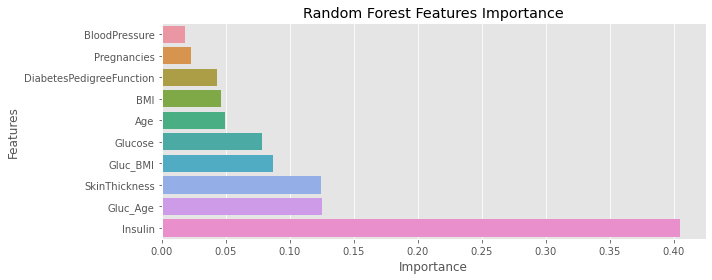

In [392]:
feats = zip(X.columns, rfgs.best_estimator_.feature_importances_)
coefs_df = pd.DataFrame(feats, columns = ['feature', 'coef'])
coefs_df = coefs_df.sort_values(by = 'coef')
plt.figure(figsize=(10,4))
sns.barplot(x='coef', y='feature', data=coefs_df)
plt.title('Random Forest Features Importance')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.tight_layout()
plt.savefig('rfgs_coefs.png')
plt.show();

---
### Decision Tree
- Sample run and grid search cv 

In [317]:
gscv.best_estimator_

DecisionTreeClassifier(max_depth=5, max_features='auto', min_samples_leaf=11,
                       random_state=7)

In [331]:
# This DT was tuned multiple times after running thru a bunch of gridsearches
dt = DecisionTreeClassifier(max_depth=7, max_features='auto', min_samples_leaf=13, random_state=7)
dt.fit(X_train, y_train)
testpred = dt.predict(X_test)
trainpred = dt.predict(X_train)

print('Training Metrics:')
print('------------------')
print_metrics(y_train, train_preds)

print('\r')
print('Test Metrics:')
print('------------------')
print_metrics(y_test, test_preds)
print('\r')
trainK_rmse = np.sqrt(metrics.mean_squared_error(y_train, trainpred))

print('Training RMSE: ', trainK_rmse)

testK_rmse = np.sqrt(metrics.mean_squared_error(y_test, testpred))

print('Testing Root Mean Squared Error:' , testK_rmse)

Training Metrics:
------------------
Precision Score: 0.8841463414634146
Recall Score: 0.8238636363636364
Accuracy Score: 0.9027237354085603
F1 Score: 0.8529411764705882

Test Metrics:
------------------
Precision Score: 0.8433734939759037
Recall Score: 0.7608695652173914
Accuracy Score: 0.8622047244094488
F1 Score: 0.8

Training RMSE:  0.3118914307759027
Testing Root Mean Squared Error: 0.3712078603566352


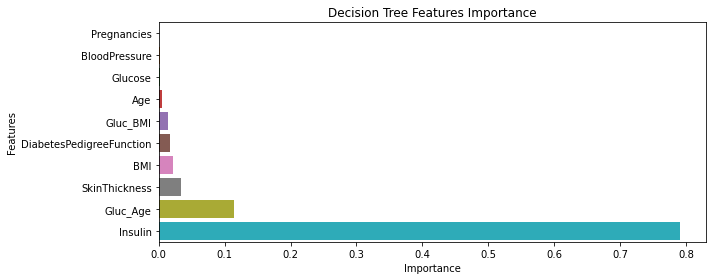

In [332]:
feats = zip(X.columns, dt.feature_importances_)
coefs_df = pd.DataFrame(feats, columns = ['feature', 'coef'])
coefs_df = coefs_df.sort_values(by = 'coef')
plt.figure(figsize=(10,4))
sns.barplot(x='coef', y='feature', data=coefs_df)
plt.title('Decision Tree Features Importance')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.tight_layout()
plt.savefig('dt_coefs.png')
plt.show();

#### Gridsearch for DT

In [161]:
param = {'max_depth' : range(1,12,1),
        'criterion': ['gini', 'entropy'],
        'splitter': ['best', 'random'],
        'max_features': ['auto', 'log2', 'sqrt'],
        'min_samples_leaf': range(3,100,2)}

gscv=GridSearchCV(dt,param_grid=param, cv=7)


In [162]:
gscv.fit(X_train, y_train)

GridSearchCV(cv=7, estimator=DecisionTreeClassifier(random_state=7),
             param_grid={'class_weight': [None, 'balanced'],
                         'criterion': ['gini', 'entropy'],
                         'max_depth': range(1, 30),
                         'max_features': ['auto', 'log2', 'sqrt'],
                         'min_samples_leaf': range(3, 100, 2),
                         'splitter': ['best', 'random']})

In [316]:
gscv.best_estimator_

DecisionTreeClassifier(max_depth=5, max_features='auto', min_samples_leaf=11,
                       random_state=7)

## KNN 
- using python to find best n_neighbor, taken from Sean's lecture 

In [377]:
def max_value(l):
    max_val = max(l)
    max_idx = l.index(max_val)
    return max_idx, max_val

In [378]:
#create a container to track the scores
k_scores=[]

#set up a loop to fit the model using a different values of K

k_range = list(range(1, 21))
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    #fit the model and get the score on a evaluation metric
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    
    acc = accuracy_score(y_test, y_pred)
    
    k_scores.append(acc)
    

#use the max_value function to find the K value that gives you the best accuracy pred 
idx, val = max_value(k_scores)

    
print(idx+1, val)

11 0.8228346456692913


In [379]:
X = d_new.drop(columns='Outcome', axis=1)
y = d_new.Outcome

# splitting into testing and training data 
X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=7,test_size=0.33)

# instantiating the normal scaler class
scaler = StandardScaler()

# fit the scaler to the training data
scaler.fit(X_train)

#transform the training data and re-assign X_train 
X_train = pd.DataFrame(data=scaler.transform(X_train), columns=X.columns)

#transform the testing data and re-assign X_test
X_test = pd.DataFrame(data=scaler.transform(X_test), columns=X.columns)

In [380]:
knn = KNeighborsClassifier(n_neighbors=20)
knn.fit(X_train, y_train)
trainpred = knn.predict(X_train)
testpred = knn.predict(X_test)
print_metrics(y_train, trainpred)
print('\n')
print_metrics(y_test, testpred)

Precision Score: 0.8
Recall Score: 0.6590909090909091
Accuracy Score: 0.8268482490272373
F1 Score: 0.7227414330218068


Precision Score: 0.7093023255813954
Recall Score: 0.6630434782608695
Accuracy Score: 0.7795275590551181
F1 Score: 0.6853932584269663


### KNN with GridSearchCV

In [381]:
X = d_new.drop(columns='Outcome', axis=1)
y = d_new.Outcome

# splitting into testing and training data 
X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=7,test_size=0.33)

# instantiating the normal scaler class
scaler = StandardScaler()

# fit the scaler to the training data
scaler.fit(X_train)

#transform the training data and re-assign X_train 
X_train = pd.DataFrame(data=scaler.transform(X_train), columns=X.columns)

#transform the testing data and re-assign X_test
X_test = pd.DataFrame(data=scaler.transform(X_test), columns=X.columns)

In [382]:
knn = KNeighborsClassifier()

In [383]:
param = {'n_neighbors': range(0,18,1),
        'weights': ['uniform', 'distance'],
        'metric': ['manhattan', 'euclidean', 'minokwski']}

In [384]:
gsknn = GridSearchCV(knn, param, cv=7, scoring='f1', n_jobs=-1)

In [385]:
gsknn.fit(X_train, y_train)

GridSearchCV(cv=7, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'metric': ['manhattan', 'euclidean', 'minokwski'],
                         'n_neighbors': range(0, 18),
                         'weights': ['uniform', 'distance']},
             scoring='f1')

In [386]:
print(gsknn.best_params_)
print(gsknn.best_estimator_)

{'metric': 'manhattan', 'n_neighbors': 13, 'weights': 'uniform'}
KNeighborsClassifier(metric='manhattan', n_neighbors=13)


In [387]:
testpred=gsknn.best_estimator_.predict(X_test)
trainpred=gsknn.best_estimator_.predict(X_train)


print('Training Metrics:')
print('------------------')
print_metrics(y_train, trainpred)

print('\r')
print('Test Metrics:')
print('------------------')
print_metrics(y_test, testpred)

trainK_rmse = np.sqrt(metrics.mean_squared_error(y_train, trainpred))

print('Training RMSE: ', trainK_rmse)

testK_rmse = np.sqrt(metrics.mean_squared_error(y_test, testpred))

print('Testing Root Mean Squared Error:' , testK_rmse)

Training Metrics:
------------------
Precision Score: 0.8323353293413174
Recall Score: 0.7897727272727273
Accuracy Score: 0.8735408560311284
F1 Score: 0.8104956268221574

Test Metrics:
------------------
Precision Score: 0.776595744680851
Recall Score: 0.7934782608695652
Accuracy Score: 0.84251968503937
F1 Score: 0.7849462365591399
Training RMSE:  0.3556109446696932
Testing Root Mean Squared Error: 0.39683789506627254


### Voting Classifier

In [338]:
X = d_new.drop(columns='Outcome', axis=1)
y = d_new.Outcome

# splitting into testing and training data 
X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=7,test_size=0.33)

# instantiating the normal scaler class
scaler = StandardScaler()

# fit the scaler to the training data
scaler.fit(X_train)

#transform the training data and re-assign X_train 
X_train = pd.DataFrame(data=scaler.transform(X_train), columns=X.columns)

#transform the testing data and re-assign X_test
X_test = pd.DataFrame(data=scaler.transform(X_test), columns=X.columns)

In [339]:
# Training classifiers

voting = VotingClassifier(estimators=[('dt', dt), ('knn', gsknn.best_estimator_), 
                                     ('rf', rfgs.best_estimator_), ('logreg', final_logreg)],voting='soft', )

voting.fit(X_train, y_train)

VotingClassifier(estimators=[('dt',
                              DecisionTreeClassifier(max_depth=7,
                                                     max_features='auto',
                                                     min_samples_leaf=13,
                                                     random_state=7)),
                             ('knn',
                              KNeighborsClassifier(metric='manhattan',
                                                   n_neighbors=13)),
                             ('rf',
                              RandomForestClassifier(class_weight='balanced',
                                                     criterion='entropy',
                                                     max_depth=5,
                                                     n_estimators=50, n_jobs=-1,
                                                     random_state=7)),
                             ('logreg',
                              LogisticRegression(C=0.1, 

In [341]:
trainpreds=voting.predict(X_train)
testpreds = voting.predict(X_test)
print('Training Metrics:')
print('------------------')
print_metrics(y_train, trainpreds)

print('\r')
print('Test Metrics:')
print('------------------')
print_metrics(y_test, testpreds)

trainK_rmse = np.sqrt(metrics.mean_squared_error(y_train, trainpreds))

print('Training RMSE: ', trainK_rmse)

testK_rmse = np.sqrt(metrics.mean_squared_error(y_test, testpreds))

print('Testing Root Mean Squared Error:' , testK_rmse)

Training Metrics:
------------------
Precision Score: 0.8648648648648649
Recall Score: 0.9090909090909091
Accuracy Score: 0.9202334630350194
F1 Score: 0.8864265927977839

Test Metrics:
------------------
Precision Score: 0.8064516129032258
Recall Score: 0.8152173913043478
Accuracy Score: 0.8622047244094488
F1 Score: 0.8108108108108107
Training RMSE:  0.2824297026960524
Testing Root Mean Squared Error: 0.3712078603566352
